# <center>用随机森林模型预测AB3类化合形成能</center>

## 1. 数据提取

#### 从Materials Project库中提取AB3化合物，其中B元素被限制为F、Cl、Br、I、O、S这几种元素

In [62]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval  
import pandas as pd
mpdr = MPDataRetrieval('FVdCyM5w7RKmqkQW') #mpdr = MPDataRetrieval('API_keys')，API_keys可以通过在 materialsproject.org 注册账号获取。
df1 = mpdr.get_dataframe(criteria="*I3",
                       properties=["material_id","pretty_formula","structure","formation_energy_per_atom",
                                  "space_group"])
df2 = mpdr.get_dataframe(criteria="*Cl3",
                       properties=["material_id","pretty_formula","structure","formation_energy_per_atom",
                                   "space_group"])
df3 = mpdr.get_dataframe(criteria="*Br3",
                       properties=["material_id","pretty_formula","structure","formation_energy_per_atom",
                                   "space_group"])
df4 = mpdr.get_dataframe(criteria="*F3",
                       properties=["material_id","pretty_formula","structure","formation_energy_per_atom",
                                   "space_group"])
df5 = mpdr.get_dataframe(criteria="*O3",
                       properties=["material_id","pretty_formula","structure","formation_energy_per_atom",
                                   "space_group"])
df =pd.concat([df1,df2,df3,df4,df5])
df.head()

E:\anaconda\Anaconda\lib\site-packages\pymatgen\core\periodic_table.py:429: UserWarning:

No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

E:\anaconda\Anaconda\lib\site-packages\pymatgen\core\periodic_table.py:429: UserWarning:

No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

E:\anaconda\Anaconda\lib\site-packages\pymatgen\core\periodic_table.py:429: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



,pretty_formula,structure,formation_energy_per_atom,space_group
material_id,,,,
mp-861867,AcI3,[[-4.18086853e-06 6.69441981e+00 3.29269827e...,-1.518260,None
mp-30930,AlI3,"[[0.01919453 7.87930235 9.71751862] Al, [3.389...",-0.672347,None
mp-23218,AsI3,"[[1.69059523 1.12964843 3.48983325] As, [ 7.68...",-0.199379,None
mp-23189,BI3,[[-7.23678818e-07 4.27379473e+00 2.20867776e...,-0.063909,None
mp-1008490,BiI3,"[[0. 0. 0.] Bi, [-4.06613046 -4.06613046 -4.06...",0.115729,None


#### 这里我们只需要formation_energy_per_atom和pretty_formula两列

In [63]:
df= df[["formation_energy_per_atom","pretty_formula"]]
df.head()

,formation_energy_per_atom,pretty_formula
material_id,,
mp-861867,-1.518260,AcI3
mp-30930,-0.672347,AlI3
mp-23218,-0.199379,AsI3
mp-23189,-0.063909,BI3
mp-1008490,0.115729,BiI3


#### 对列进行重新命名，让后面流程显得更加直观

In [64]:
df = df.rename(columns={'pretty_formula':'composition','formation_energy_per_atom':'formation_energy'})
df.head()

,formation_energy,composition
material_id,,
mp-861867,-1.518260,AcI3
mp-30930,-0.672347,AlI3
mp-23218,-0.199379,AsI3
mp-23189,-0.063909,BI3
mp-1008490,0.115729,BiI3


## 2. 生成训练集(数据预处理）

#### 记下来我们仅仅保留每个化合物形成能最低的entry，数据库中提取的化合物的形成能可能不唯一，可能存在多个enrty

#### matminer可以通过化学组分来得到输入数据进行特征化处理

#### 第一步需要将表示化学组分的composition列转换成pymatgen Composition object

In [65]:
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition(target_col_id='composition_obj').featurize_dataframe(df, 'composition')
df.head()

,formation_energy,composition,composition_obj
material_id,,,
mp-861867,-1.518260,AcI3,"(Ac, I)"
mp-30930,-0.672347,AlI3,"(Al, I)"
mp-23218,-0.199379,AsI3,"(As, I)"
mp-23189,-0.063909,BI3,"(B, I)"
mp-1008490,0.115729,BiI3,"(Bi, I)"


#### 移除不存在形成能的entry

In [66]:
#for k in ['formation_energy_per_atom']: 
#    df[k] = pd.to_numeric(df[k])
original_count = len(df)
df = df[~ df['formation_energy'].isnull()]
print('Removed %d/%d entries'%(original_count - len(df), original_count))  #会发现没有减少entry

Removed 0/520 entries


#### 仅仅保留每个化合物的基态entry，使得最终每个化合物仅仅有一个entry

In [67]:
%%time
original_count = len(df)
df['composition'] = df['composition_obj'].apply(lambda x: x.reduced_formula)
df.sort_values('formation_energy', ascending=True, inplace=True)
df.drop_duplicates('composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(df), original_count))

Removed 250/520 entries
Wall time: 56 ms


#### 移除异常值

In [68]:
import numpy as np
original_count = len(df)
df = df[np.logical_and(df['formation_energy'] >= -20, df['formation_energy'] <= 5)]
print('Removed %d/%d entries'%(original_count - len(df), original_count))

Removed 0/270 entries


## 3. 搭建随机森林模型

#### 3.1 计算表示（representation）

#### 搭建模型的第一步是将原始(raw)的材料数据转换成数值属性(attributes)列表,才能被模型使用

In [69]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

#### 计算特征(feature)

In [70]:
feature_labels = feature_calculators.feature_labels()
df = feature_calculators.featurize_dataframe(df, col_id='composition_obj')
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in df[feature_labels].shape]))


Generated 145 features
Training set size: 270x145


#### 移除含有NaN和infinite的特征

In [71]:
original_count = len(df)
df = df[~ df[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(df), original_count))

Removed 0/270 entries


#### 3.2 调整模型超参数

In [72]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
model = GridSearchCV(RandomForestRegressor(n_estimators=100,random_state=0 ),#决策树的个数为10
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))
    #test_size=0.5表示用多少数据做为模型的训练集       
    #用GridSearchCV进行自动调参，只要把参数输进去，就能给出最优化的结果和参数，该方法适用于小数据集合

#### 进行训练

In [73]:
model.fit(df[feature_labels], df['formation_energy'])

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': range(8, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

#### 得到调参结果

In [74]:
model.best_score_

-0.7382302143965899

Text(0, 0.5, 'RMSE (eV/atom)')

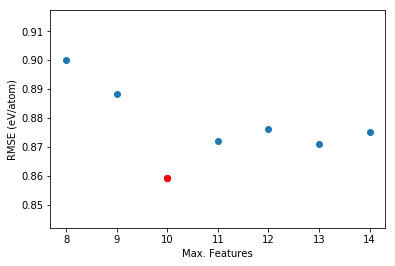

In [75]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

#### 保存最佳模型

In [76]:
model = model.best_estimator_

## 3.3交叉验证

#### 通过十折交叉验证来量化得出模型的表现

In [77]:
cv_prediction = cross_val_predict(model, df[feature_labels], df['formation_energy'], cv=KFold(10, shuffle=True))

#### 计算汇总数据

In [78]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(df['formation_energy'], cv_prediction)
    print(scorer, score)

r2_score 0.8602991958415255
mean_absolute_error 0.2793530952324749
mean_squared_error 0.20255167769467616


In [79]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

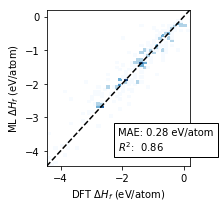

In [80]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(df['formation_energy']), cv_prediction, norm=LogNorm(), bins=64, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(df['formation_energy'], cv_prediction)
r2 = metrics.r2_score(df['formation_energy'], cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)

#### 特征重要程度比较

In [81]:
feature_importance = model.feature_importances_
feature_importance

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.31056400e-03, 3.02336864e-03,
       1.16599890e-02, 5.03807141e-03, 1.23864057e-02, 2.29843056e-03,
       1.15830748e-02, 2.25840426e-03, 5.98021599e-03, 1.56280129e-02,
       8.74387011e-03, 3.77881606e-03, 7.13014727e-03, 3.12304137e-03,
       6.12668267e-03, 6.57027753e-03, 7.14112884e-03, 7.33737751e-04,
       1.51302047e-02, 8.71837919e-03, 6.99276182e-03, 6.80034922e-03,
       1.26919345e-02, 1.65478061e-02, 8.63086739e-03, 9.07637723e-04,
       6.07021183e-03, 1.21888489e-02, 8.01575241e-03, 1.03021174e-03,
       1.00396692e-03, 1.85586563e-03, 4.67997995e-03, 1.70237108e-03,
       4.51535867e-03, 5.21944648e-03, 3.36603644e-03, 1.17074235e-02,
       3.50621697e-02, 5.55448487e-03, 5.16842228e-02, 2.63631095e-02,
       1.74377838e-02, 1.92042219e-02, 4.91428794e-02, 3.47781181e-02,
       7.04597394e-02, 1.69448692e-02, 1.94416555e-03, 0.00000000e+00,
      